In this lab we will look at modeling an Ising system with Monte Carlo.
If you are unfamiliar with Python, a set of tutorials can be found [here](https://www.learnpython.org/en/Welcome).
From the tutorials linked above listed under Python basics, you are to be familiar with:
- Variables & Types
- Lists
- Basic Operators
- Conditions
- Loops
- Functions

# Ising Model 

The Ising model is a lattice of $k$ interacting sites. Each site has a spin $\sigma_k$ which can have a value of +1 or -1. The spins are allowed to interact with their nearest-neighbor spins. The Hamiltonian for the system is given by:

$$
H(\sigma)=-\sum_{ a }^{k} \left(\sum_{b}^{\langle a\rangle} J \sigma_{a} \sigma_{b}\right)- h \sigma_{a}
$$

where $\langle a\rangle$ indicate a sum over only the nearest neighbors of site $a$. The interaction between spins is captured in $J$. If $J$ is positive, the spins will want to align with their neighbors or system will behave ferromagnetically. If $J$ is negative, the spins will want to antialign with their neighbors or system will behave antiferromagnetically. A magnetic field aligned with the spins is represented by $h$.

We will start by introducing some code for this model. 

To begin, we need to import the Python modules we will need. If you're not familiar with these, here is an overview: 
- `numpy` allows us to perform the necessary math
- `matplotlib` will allows us to visualize our results
- `pandas` will help up tabulate data cleanly
- `pyblock` handles reblocking, which will be discussed later in the notebook

The cell below will ensure you have all necessary packages installed

In [72]:
%pip install numpy matplotlib pyblock pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyblock
import pandas as pd
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

We'll also import some helper utilities that we wrote to make things easier for you

In [73]:
import ising_utils as iu

# Ising Model Parameters
We will store the information about a $M$ by $N$ 2D lattice of spins using a dictionary like below:

In [74]:
ip = {"J": None, "h": None, "M": None, "N": None}

# Initializing a lattice
The function below takes a dictionary of Ising model parameters `ip` and initializes a lattice to be all spin up.

The lattice state will be stored as a $M$ by $N$ array of 1 and -1 which will represent spin up and down respectively.

In [75]:
def initialize_lattice_state(ip):
    """
    Initializing the lattice of size MxN to all ones
    """
    lattice_state = np.ones((ip["M"], ip["N"]))
    return lattice_state

The code below initializes an example $3\times3$ lattice with $J = 1, h = 0$.

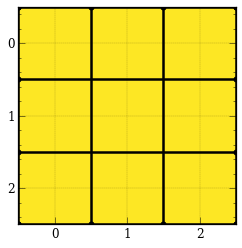

In [76]:
# Initializing a model of 3x3 spins, with J = 1 and h = 0
ip = {"J": 1, "h": 0 , "M": 3, "N": 3}
example_lattice = initialize_lattice_state(ip) 
# visualize the lattice
iu.plot_lattice(example_lattice)

## Exercise 1: Initialize an example lattice

Use the function above to initialize an example $5\times8$ lattice with $J = 2, h = 0.01$.

1. Create a dictionary of Ising model parameters named `ip`
2. Call the function `initialize_lattice_state` above with `ip` as an argument. Store the result in a variable named `lattice`

In [77]:
# place code to initialize here
ip = {"J": 2, "h": 0.01 , "M": 5, "N": 8}
lattice = initialize_lattice_state(ip) 

In [78]:
iu.check_exercise_1(ip, lattice)

Check: OK
The variable 'ip' exists.
Check: OK
The variable 'ip' is a dictionary.
Check: OK
The variable 'lattice' exists.
Check: OK
The variable 'lattice' is a numpy array.
Check: OK
The dictionary 'ip' has the right keys and they aren't 'None'.
Check: OK
The variable 'ip' has all the right values in it.
Check: OK
The shape of 'lattice' is correct and is all set to 1.


## Coding functions for the model
Next, you will be coding your first functions for the model. 

The functions we will need to create are: 
- the ability to flip a specific spin within the lattice
- the ability to go through each lattice site to calculate the energy of the lattice.
- a function to calculate the energy per site.



```python
 def function_name(ARGUMENTS HERE):
        CODE HERE
 ```
 
 
 We will first start with the function to flip (i.e. at a specific site in the lattice, $ i $, $ j $, the spin will flip and that lattice site will be the negative of itself.)


In [9]:
def flip_spin(lattice_state, i, j):
    """
    Flip spin (i, j)
    i.e. -1 ---> 1
          1 ---> -1
    """
    new_lattice_state = np.copy(lattice_state)
    new_lattice_state[i, j] = -new_lattice_state[i, j]
    return new_lattice_state

## Excercise 2
As you did above initaite a new 3x3 lattice, with J = 1 and h = 0. 
Place the lattice in a variable called `example_lattice`.
Use the `flip_spin` function you wrote above twice to flip the spin at (0,1) and then at (2,2).


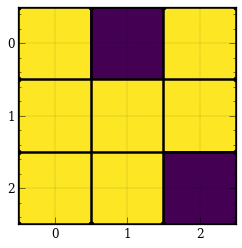

In [79]:
ip = {"J": 1, "h": 0 , "M": 3, "N": 3}
example_lattice = initialize_lattice_state(ip) 
example_lattice = flip_spin(example_lattice, 0, 1)
example_lattice = flip_spin(example_lattice, 2, 2)
iu.plot_lattice(example_lattice)

In [81]:
#DO NOT MODIFY THIS CELL
iu.check_exercise_2(ip, example_lattice)

Check: OK
The variable 'ip' has all the right values in it.
Check: OK
The shape of 'lattice' is correct.
Check: OK
The correct spins of 'lattice' were flipped.
Check: OK
No incorrect spins were flipped.


# Calculating the contributions to a lattice sites

The next function we want to write is the function to calculate the energy contributions of a specific site.
The total energy will be the sum of this function over all sites and correcting for double counting.

Our model will implement periodic boundary conditions (PBC) to approximate a large infinite system with a small unit cell.
Breifly stated, a single lattice state will also feel the affect of having a repeated lattice state to the top, bottom, left, and right.
We will build our understanding of PBC using the diagram below. 

<img src="pbc.png" width="60%">

Here, we have described a unit cell as a 3 x 3 lattice, which we visualize as the center block of this image (the one containing the red dot).
Each dot represents a lattice site which either has a +/-1 spin.
Let's explore the interactions felt by the center unit cell above, specifically the red dot.
Where the red dot in the individual unit cell will interact with other sites within the unit cell such as the yellow sites.
Additionally, to model the bulk system, it will also feel the effect of sites outside of the reference cell, indicated by the blue dots.
The situations where a site is feeling contributions from other unit cells will happen on all edges. 
As such, they are colloquially reffered to as edge cases.
Conveniently, instead of storing multiple versions of our lattice, we can instead realize that the blue points are also found in the unit cell and we can thus stick to referencing a single unit cell.
This will then require some clever coding on our part.


# Exercise: calculate the contributions of a site

We will first focus on writing the energy contributions of the single site.
The function below will return those contributions.
This will require knowledge of the spins on all neighbors of the central site $i$, $j$.

There will be boundary cases to consider:
   - If you are along the top edge of the lattice, $j == 0$.
   - If you are along the bottom edge of the lattice, $j == N-1$.
   - If you are along the left edge of the lattice, $i == 0$.
   - If you are along the right edge of the lattice, $i == M-1$.

Recall that python indexing starts from 0 which is why $M-1$ and $N-1$ describe the right and bottom edge respectively rather than $M$ and $N$.

Once we have the values of the neighboring spins, the interactions of a specific lattice site with the external field and the neighboring sites is expressed as:

$$E = -h\sigma_{ij} - J
\sigma_{ij}(\sigma_{i+1,j}+\sigma_{i-1,j}+\sigma_{i,j+1}+\sigma_{i,j-1})$$



In [36]:
def calculate_energy_contrib_of_site(lattice_state, ip, i, j):
    """
    Calculate energy of spin (i, j)

    Periodic boundary conditions implemented
    """
    spin_here = lattice_state[i, j]  # value of spin here

    # value of spin above, below, left, and right of spin (i, j)
    # for each, if on boundary, we wrap around to the other side
    # of the lattice for periodic boundary conditions
    if j == 0:
        spin_left= lattice_state[i, ip["N"] - 1]
    else:
        spin_left= lattice_state[i, j - 1]

    if j == (ip["N"] - 1):
        spin_right = lattice_state[i, 0]
    else:
        spin_right = lattice_state[i, j + 1]

    if i == (ip["M"] - 1):
        spin_below = lattice_state[0, j]
    else:
        spin_below = lattice_state[i + 1, j]

    if i == 0:
        spin_above = lattice_state[ip["M"] - 1, j]
    else:
        spin_above = lattice_state[i - 1, j]
    return (-ip["h"] * spin_here) - (ip["J"] * spin_here * (
        spin_above + spin_below + spin_left + spin_right))

## Excercise 3
The code in the cell below will test the `calculate_energy_of_site` function you wrote above. Pay attention to the output to see if you made any errors in `calculate_energy_of_site`.

Testing function with no external field
	3 by 3 lattice
	J = 1   (positive means a favorable interaction)
	h = 0.0   (external field aligned with spins)


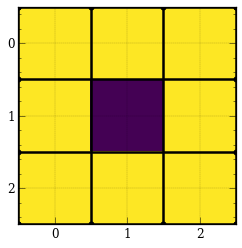

Expected:
[[-2. -1. -2.]
 [-1.  2. -1.]
 [-2. -1. -2.]]
Calculated:
[[-4. -2. -4.]
 [-2.  4. -2.]
 [-4. -2. -4.]]
Test failed!

Testing function with an external field
	3 by 3 lattice
	J = 1   (positive means a favorable interaction)
	h = 0.01   (external field aligned with spins)


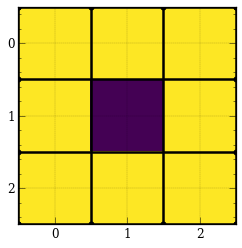

Expected:
[[-2.01 -1.01 -2.01]
 [-1.01  2.01 -1.01]
 [-2.01 -1.01 -2.01]]
Calculated:
[[-4.01 -2.01 -4.01]
 [-2.01  4.01 -2.01]
 [-4.01 -2.01 -4.01]]
Test failed!


In [80]:
#DO NOT MODIFY THIS CELL
iu.check_exercise_3(initialize_lattice_state,flip_spin, calculate_energy_of_site)

# Additional functions for observables of the model

However, looping over all sites and calculating the energy contributions of a site suffers from double counting of the sites.
You can think about this as the site $\sigma_{i,j}$ will show up in this expression but also for the the iteration assessing $\sigma_{i+1,j}$. Thus, we reduce the contribution of J by a factor of 2 when calculating the total energy. Thus the final expression for the energy of a site is: 

$$E = - \frac{-2h\sigma_{ij} - J
\sigma_{ij}(\sigma_{i+1,j}+\sigma_{i-1,j}+\sigma_{i,j+1}+\sigma_{i,j-1})}{2}$$

This lets us loop over all sites and calculate the total energy as a sum over the site energies.

We have provided a set of functions to calculate other obervables.
These calculate the instantaneous value of the observable, and we will be interested in the ensemble average of these values.

- The total spin $s$
- The total spin per particle $\frac{s}{M\times N}$
- The total energy $E$
- The total energy per particle $\frac{E}{M \times N}$

In [61]:
def calculate_total_spin(lattice_state):
    """
    Calculate total spin of the lattice
    """
    return np.sum(lattice_state)


def calculate_total_spin_per_spin(lattice_state, ip):
    """
    Calculate total spin of the lattice
    """
    return calculate_total_spin(lattice_state) / (ip["M"] * ip["N"])


def calculate_total_energy(lattice_state, ip):
    """
    Calculate total energy of the lattice
    """
    E = 0.0
    for i in range(ip["M"]):
        for j in range(ip["N"]):
            E += calculate_energy_contrib_of_site(lattice_state, ip, i, j)
    return (E - ip['h']*calculate_total_spin(lattice_state))/2


def calculate_total_energy_per_spin(lattice_state, ip):
    """
    Calculate energy of lattice normalized by the number of spins
    """
    return calculate_total_energy(lattice_state, ip) / (ip["M"] * ip["N"])



# Monte Carlo Simulations

Now that we have a model for the ising lattice, we are ready to calculate the observables of interest. 
An observable can be calculated as a weighted sum over states 
$$
\langle O\rangle=\sum_{\alpha} O(\alpha) P(\alpha)
$$
For example, for the expectation value of the energy of an $M \times N$ lattice, the expectation value would be

$$
\langle E\rangle=\sum_{\alpha} E(\alpha) P(\alpha)
$$

where the probability distribution $P(\alpha)$ is

$$
P(\alpha) = \frac{e^{-\beta E_{\alpha}}}{\sum_{i} e^{-\beta E_{i}}}
$$

where $E(\alpha)$ is the energy of a fixed state $\alpha$, and  $P(\alpha)$ is the probability of being in that fixed state.
It is worth noting that this approach is true for any other property as well, not just the energy.
However, the number of fixed states grows as $2^{(N*M)}$ where $N*M$ is the total number of lattice points.
Exactly calculating the cotributions for every possible lattice state quickly becomes impractical as the lattice size grows.
Additionally we don't know the probability of being in each state since we cannot compute the denominator.

One way to deal with this is Monte Carlo sampling, which can be used to estimate the probability distribution by using a random distribution of $n$ points in the configuation space (i.e. the space of all possible lattices): 
$$
\langle E\rangle = \frac{\sum_{n} E(n)e^{-\beta E_{n}}}{\sum_{n} e^{-\beta E_{n}}}
$$
However, by simply choosng $n$ random lattices from the configuration space, there is no guarantee that we have sampled enough points that are representative of $P(\alpha)$.

To address this, we sample lattices drawn from the probability distribution $P(\alpha)$.
This may seem weird since we just said that we do not know the distribution $P(\alpha)$, however using the Metropolis algorithm we can sample from an unknown distribution.

To understand this consider starting at a certain lattice configuration $X$. The probability of being at state $X$ is:
$$
P(X) = \frac{e^{-\beta E_{X}}}{\sum_{i} e^{-\beta E_{i}}}
$$
If we generate a new configuration $Y$, the probability of being at lattice $Y$ is given by P($Y$):
$$
P(Y) = \frac{e^{-\beta E_{Y}}}{\sum_{i} e^{-\beta E_{i}}}
$$
The probability of moving from $X$ to $Y$ is the ratio of these two probabilities:
$$
P(Y \leftarrow X) = e^{-\beta (E_{Y} - E_{X})}
$$
Notice that the denominators now drop out! Therefore if we generate lattice configurations and accept new configurations according to this probability then the generated configurations will be distributed according to $P(\alpha)$. 
The acceptance probability of a new move is:
$$
P_{\mathrm{accept}} = min\left(1,\frac{P(Y)}{P(X)}\right)
$$
This also indicates the need for an equilibration period.
If the first sample $X$ is not from a region of high probability, samples must be drawn from $P(\alpha)$ until some steady state is reached.

The algorithm is now:
- Generate an initial configuration
- equilibrate
- for N samples
    - generate a trial configuration
    - calculate the metropolis acceptance probability $e^{-\beta (E_{Y} - E_{X})}$
    - draw a uniform random number
    - if the random number <= P_accept
        - update the initial configuration to be the current configuration
    - else
        - stay at the current configuration (i.e. don't update the initial configuration)
 
Notice that this means if a trial configuration is lower in energy it is always accepted. If a trial configuration is higher in energy than it is accepted with probability $P_{accept}$.



The simulation parameters and simulation results will be stored in dictionaries. The simulation parameters are the number of equilibration sweeps (`num_equil_sweeps`), the number of production sweeps(`num_sample_sweeps`), and kT (`kT`).

During the simulation we want to record the observables that we would like ensemble averages of: the energy per site `energy_list` and the total spin per site `total_spin_list`.

In [62]:
# simulation parameters
sp = {"num_equil_sweeps": None, "num_sweeps": None, "kT": None}
# simulation results:
sr = {"energy_list": [], "total_spin_list": []}

## Exercise 4 Metropolis test
Above the probability to accept a new configuration was given by $P_{\mathrm{accept}}$.
This function will return a boolean value (True or False) depending on if the new configuration is accepted.
This function will receive the energy of the current configuration (`E_old`) and the trial configuration (`E_new`) and the simulation parameters (`sp`).
The code to generate a random number sampled from a uniform distribution between 0 and 1 in python using `numpy` is `np.random.random()`.

In [63]:
def metropolis_test(sp, E_new, E_old):
    if np.random.random() <= np.exp(-(E_new - E_old) / sp["kT"]):
        return True
    else:
        return False

In [64]:
# THIS IS THE TEST FOR THE FUNCTION THE STUDENTS WRITE
# set some parameters
sp = {"num_equil_sweeps": None, "num_sweeps": None, "kT": 1}
E_new = 0.47
E_old = 0.1
# since this function is probabilistic we will sample it ~N times 
# and check that we are within 3 sigma of the expected value
nsamp = 100000
# expected
P_accept = np.exp(-(0.47 - 0.1) / sp["kT"])
# calculated (metropolis_test is run nsamp times and the mean of the trues (1) and falses (0) gives the probability)
P_func = np.mean(np.array([metropolis_test(sp, E_new, E_old) for i in range(nsamp)]))
# assert it is within 3 sigma
assert np.abs(P_func-P_accept) <= 2*(1.0/np.sqrt(nsamp))

# print(P_accept)
# print(P_func)
# print(np.abs(P_func-P_accept))
# print((1.0/np.sqrt(nsamp)))
# print(np.abs(P_func-P_accept) <= 3*(1.0/np.sqrt(nsamp)))


When generating new configurations, we could do a number of things.
For example we could pick a spin at random and flip it and test if we accept it. 
Or we could sweep through the lattice and flip each spin and test if we accept it.
Here we choose the latter:

In [65]:
def sweep(lattice_state, ip, sp):
    for site_i in range(ip["M"]):
        for site_j in range(ip["N"]):
            E_old = calculate_energy_contrib_of_site(lattice_state, ip, site_i, site_j)
            # flip spin i and j
            new_lattice_state = flip_spin(lattice_state, site_i, site_j)
            # calculate updated energy
            E_new = calculate_energy_contrib_of_site(new_lattice_state, ip, site_i, site_j)
            # Monte Carlo step
            if metropolis_test(sp, E_new, E_old):
                # accept move
                E_old = E_new
                lattice_state = np.copy(new_lattice_state)
            else:
                # reject move
                # do nothing just continue
                continue
    return lattice_state

These functions calculate some of the statistics for you. 
The mean and standard error of the mean of the energy per site and spin per site.

In [66]:
def get_average_energy(sr):
    return np.mean(sr["energy_list"])


def get_stderr_energy(sr, sp):
    return np.std(sr["energy_list"]) / np.sqrt(sp["num_sample_sweeps"])


def get_average_spin(sr):
    return np.mean(sr["total_spin_list"])


def get_stderr_spin(sr, sp):
    return np.std(sr["total_spin_list"]) / np.sqrt(sp["num_sample_sweeps"])

However, these expression are serially correlated. For example, the energy for one sweep is not statistically independent from previous or following sweeps. To remove this correlation, one can average over short blocks of data, a process known as reblocking. This removes serial correlation because each block is now statistically independent.

The reblocking implementation of mean and standard error function are included in the ising_utils as:

`iu.get_reblocked_avg_stderr_spin`

`iu.get_reblocked_avg_stderr_energy`

You will see these functions being called later in the simulation.

The next function will run a simulation.
The arguments required are `ip` for the Ising model parameters and `sp` for the simulation parameters.

This function will return a dictionary, `sr` containing the simulation results.
The two statistics to collect per simulation step are the energy of the lattice (`sr['energy_list']`) and the total sping of the lattice (`sr['total_spin_list']`)

The simulation takes the following steps:
1. initialize the lattice state
2. A number of equilibration steps are done in which statistics are not collected.
3. A number of production steps are done.


In [67]:
def run_simulation(ip, sp):
    sr = {"energy_list": [], "total_spin_list": []}
    lattice_state = initialize_lattice_state(ip)
    for step in range(sp["num_equil_sweeps"]):
        lattice_state = sweep(lattice_state, ip, sp)
    for step in range(sp["num_sample_sweeps"]):
        lattice_state = sweep(lattice_state, ip, sp)
        # calculate total energy
        e = calculate_total_energy_per_spin(lattice_state, ip)
        sr["energy_list"].append(e)

        # calculate total s2
        s = calculate_total_spin_per_spin(lattice_state, ip)
        sr["total_spin_list"].append(s)
    return sr

# Applications

We will study the ising model under two sets of parameters. You will be tasked with making some observations about the results.

We will be comparing our simulation to that of the analytical result. The analytical result is defined as:



In [68]:
def analytical(x, J):
    analytical_solution = []
    for i in x:
        if i < 2.269:
            analytical_solution.append(
                (1 - np.sinh((2 * J) / i) ** (-4)) ** (1.0 / 8.0)
            )
        else:
            analytical_solution.append(0)

    return np.array(analytical_solution)

## Application 1
We want to simulate a system ($M$ = 30, $N$ = 30) with $J = 1$ and $h = 0$.
We want to find the transition temperature, so we will run over a list of kT values around the transition temperature. 
We will look at the kT range between 1.2 and 3.0.  
The ising model parameters are defined first:

In [69]:
# bad sampling bad lattice for quick running will remove
ip = {"N": 10, "M": 10, "J": 1, "h": 0.0}
num_equil_sweeps = 100
num_sample_sweeps = 1500
# good sampling good lattice
# ip = {"N": 30, "M": 30, "J": 1, "h": 0.0}
# num_equil_sweeps = 1000
# num_sample_sweeps = 15000


Then we calculate the analytical solution to this.

In [70]:
analytical_kT_list = np.arange(1.2, 3.0, 0.001)
s_analytical = analytical(analytical_kT_list, ip["J"])

Here, we set up list of kT values to simulate, the data structures for storing observables:
- `avg_s_list` : average spin per site 
- `stderr_s_list` : standard error of the mean of s per site
- our simulation parameters are defined for each kT, but the `num_equil_sweeps` and `num_sample_sweeps` will be the same for each kT so we define them here.

kT=1.20    mean 1.00    std_err 0.00
kT=1.30    mean 0.99    std_err 0.00
kT=1.40    mean 0.99    std_err 0.00
kT=1.50    mean 0.99    std_err 0.00
kT=1.60    mean 0.98    std_err 0.00
kT=1.70    mean 0.96    std_err 0.01
kT=1.80    mean 0.97    std_err 0.01
kT=1.90    mean 0.94    std_err 0.02
kT=2.00    mean 0.92    std_err 0.01
kT=2.10    mean -0.79    std_err 0.09
kT=2.20    mean 0.84    std_err 0.02
kT=2.30    mean -0.74    std_err 0.03
kT=2.40    mean -0.52    std_err 0.12
kT=2.50    mean -0.20    std_err 0.18
kT=2.60    mean -0.22    std_err 0.19
kT=2.70    mean 0.01    std_err 0.13
kT=2.80    mean 0.23    std_err 0.11
kT=2.90    mean 0.07    std_err 0.13


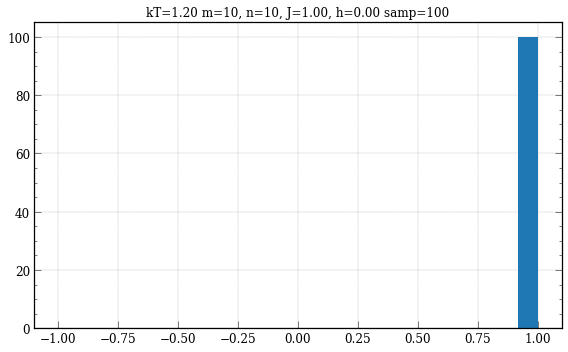

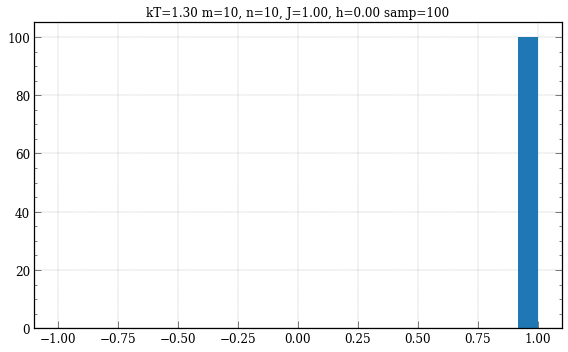

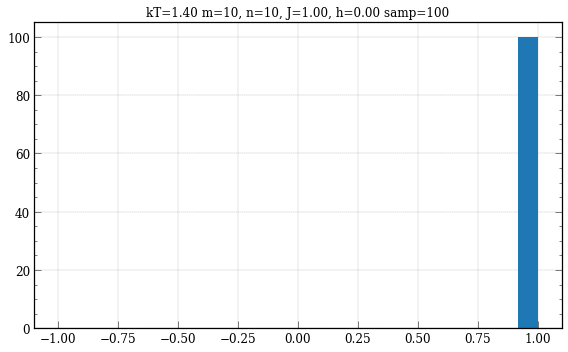

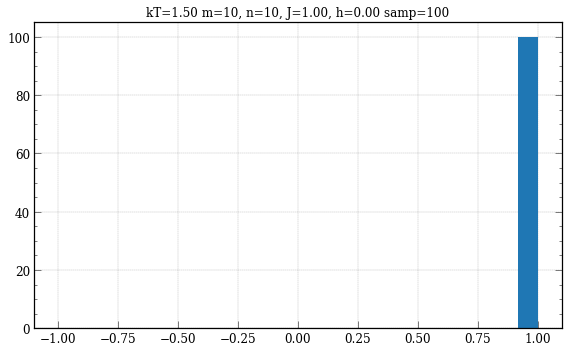

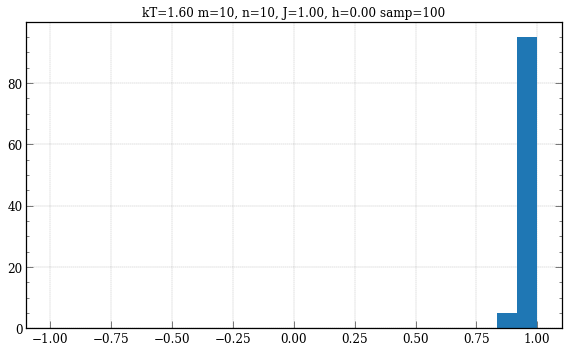

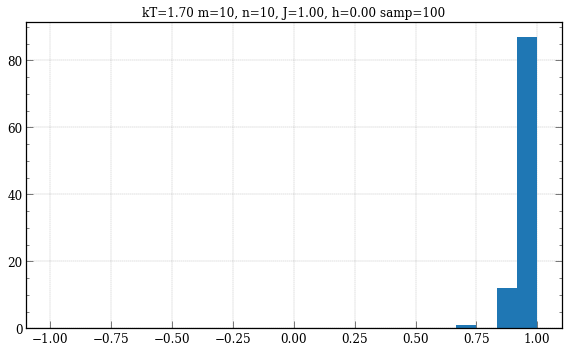

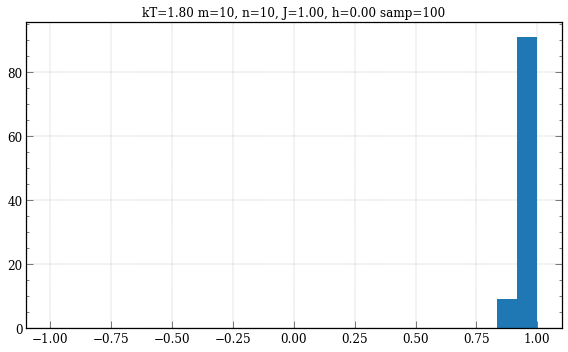

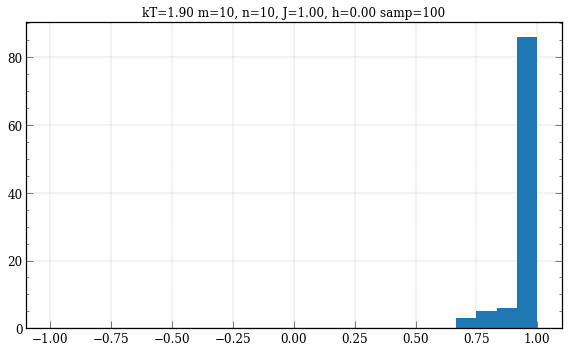

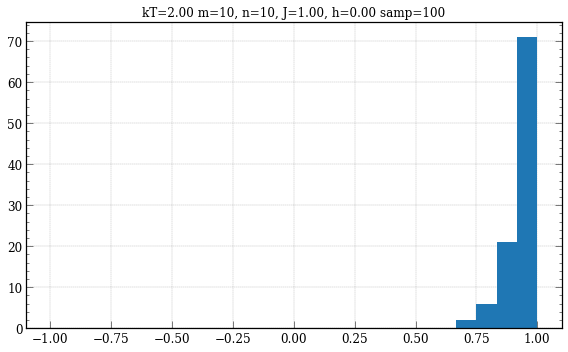

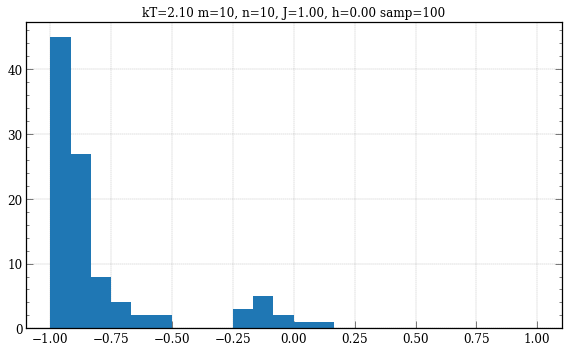

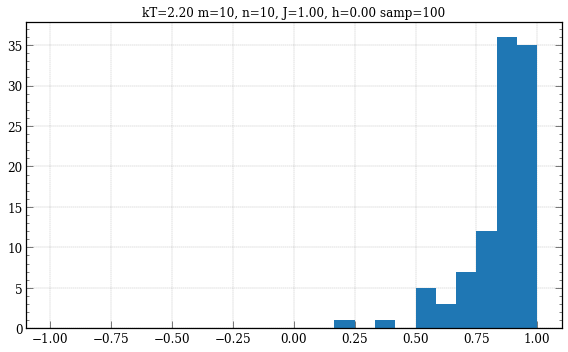

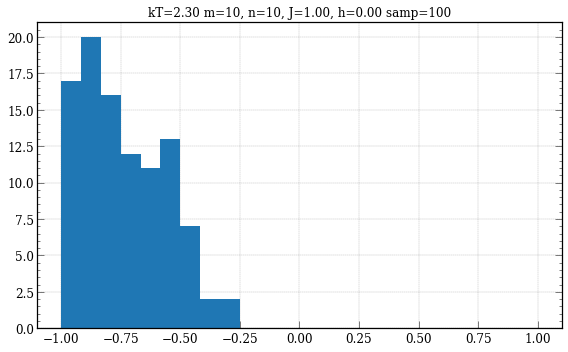

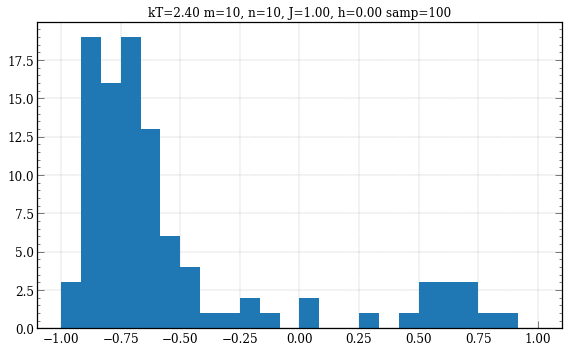

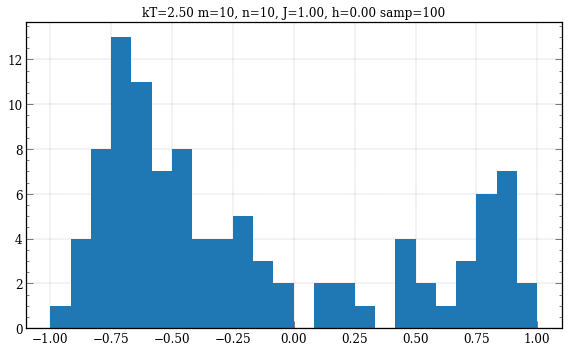

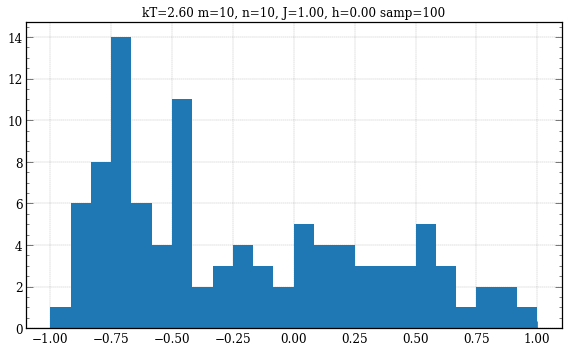

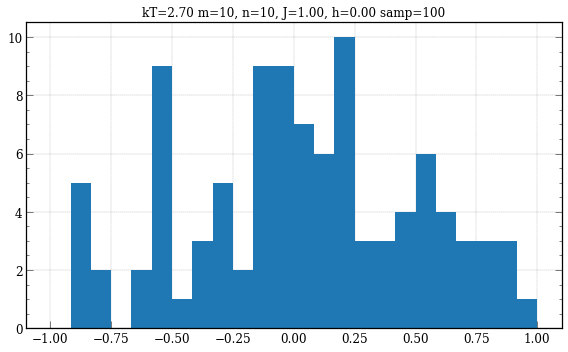

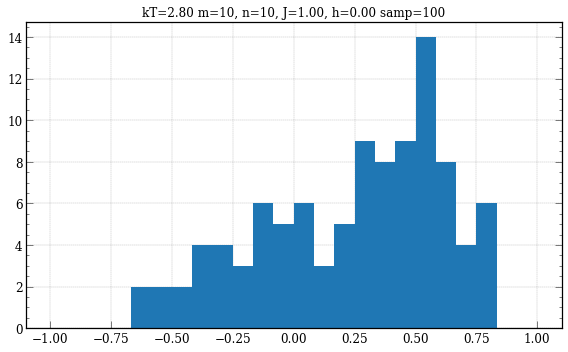

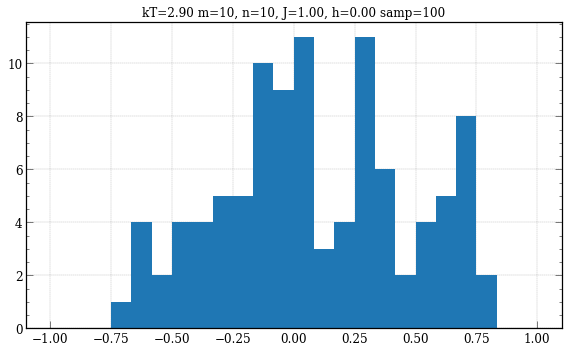

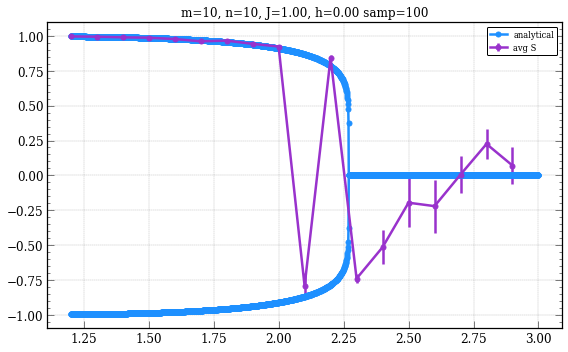

In [71]:
simulation_kT_list = np.arange(1.2, 3.0, 0.1)

avg_s_list = []
stderr_s_list = []

for kT in simulation_kT_list:
    sp = {"num_equil_sweeps": num_equil_sweeps, "num_sample_sweeps": num_sample_sweeps, "kT": kT}

    sr = run_simulation(ip, sp)
    mean, std_err = iu.get_reblocked_avg_stderr_spin(sr, sp)
    print("kT={:>4.2f}    mean {:>4.2f}    std_err {:>4.2f}".format(kT, mean, std_err))

    avg_s_list.append(mean)
    stderr_s_list.append(std_err)
    fig, ax = plt.subplots(tight_layout=True)
    fig.set_size_inches(8, 5)
    n_bins = 25
    bins = np.linspace(-1, 1, n_bins)
    ax.hist(sr["total_spin_list"], bins=bins)
    ax.set_title(
        "kT={:>4.2f} m={:>02d}, n={:>02d}, J={:>4.2f}, h={:>4.2f} samp={}".format(
            sp["kT"], ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
        )
    )
    ax.set_xlim(-1.1, 1.1)
    plt.tight_layout()
    plt.savefig(
        "metropolis_s_hist_kT_{:4.2f}_n_{:>02d}_m_{:>02d}_J_{:>4.2f}_h_{:>4.2f}_samp_{}.png".format(
            sp["kT"], ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
        ),
        dpi=200,
    )
    # plt.show()
#     s = pd.Series(sr["total_spin_list"])
#     print("avg s autocorr = {}".format(s.autocorr()))
plt.figure(figsize=(8, 5))
plt.errorbar(simulation_kT_list, avg_s_list, stderr_s_list, label="avg S",color='darkorchid')
plt.plot(analytical_kT_list, s_analytical, label="analytical",color='dodgerblue')
plt.plot(analytical_kT_list, -s_analytical,color='dodgerblue')
plt.title(
    "m={:>02d}, n={:>02d}, J={:>4.2f}, h={:>4.2f} samp={}".format(
        ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
    )
)

plt.legend()
plt.tight_layout()
plt.savefig(
    "metropolis_avg_s_m_{:>02d}_n_{:>02d}_J_{:>4.2f}_h_{:>4.2f}_samp_{}.png".format(
        ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
    ),
    dpi=200,
)
# plt.show()

# plt.show()

# Written Excercises for Zero field

Consult with Dr. Coalson

# Finite field (h=0.01)

## Application 2
Consider the previous Ising system ($M$ = 30, $N$ = 30) with $J = 1$ and now an applied field $h = 0.01$.
This should bias the system to align with the applied field

We will look at the kT range between 1.2 and 3.0.  
The ising model parameters are defined first:

In [ ]:
# bad sampling bad lattice for quick running will remove
ip = {"N": 10, "M": 10, "J": 1, "h": 0.01}
num_equil_sweeps = 100
num_sample_sweeps = 1500
# good sampling good lattice
# ip = {"N": 30, "M": 30, "J": 1, "h": 0.01}
# num_equil_sweeps = 1000
# num_sample_sweeps = 15000


Run the simulation as we did above. Note we still plot the analytical results, but those are for zero applied field.

In [ ]:
simulation_kT_list = np.arange(1.2, 3.0, 0.1)

avg_s_list = []
stderr_s_list = []

for kT in simulation_kT_list:
    sp = {"num_equil_sweeps": num_equil_sweeps, "num_sample_sweeps": num_sample_sweeps, "kT": kT}

    sr = run_simulation(ip, sp)
    mean, std_err = iu.get_reblocked_avg_stderr_spin(sr, sp)
    print("kT={:>4.2f}    mean {:>4.2f}    std_err {:>4.2f}".format(kT, mean, std_err))

    avg_s_list.append(mean)
    stderr_s_list.append(std_err)
    fig, ax = plt.subplots(tight_layout=True)
    fig.set_size_inches(8, 5)
    n_bins = 25
    bins = np.linspace(-1, 1, n_bins)
    ax.hist(sr["total_spin_list"], bins=bins)
    ax.set_title(
        "kT={:>4.2f} m={:>02d}, n={:>02d}, J={:>4.2f}, h={:>4.2f} samp={}".format(
            sp["kT"], ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
        )
    )
    ax.set_xlim(-1.1, 1.1)
    plt.tight_layout()
    plt.savefig(
        "metropolis_s_hist_kT_{:4.2f}_n_{:>02d}_m_{:>02d}_J_{:>4.2f}_h_{:>4.2f}_samp_{}.png".format(
            sp["kT"], ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
        ),
        dpi=200,
    )
    # plt.show()
#     s = pd.Series(sr["total_spin_list"])
#     print("avg s autocorr = {}".format(s.autocorr()))
plt.figure(figsize=(8, 5))
plt.errorbar(simulation_kT_list, avg_s_list, stderr_s_list, label="avg S",color='darkorchid')
plt.plot(analytical_kT_list, s_analytical, label="analytical",color='dodgerblue')
plt.plot(analytical_kT_list, -s_analytical,color='dodgerblue')
plt.title(
    "m={:>02d}, n={:>02d}, J={:>4.2f}, h={:>4.2f} samp={}".format(
        ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
    )
)

plt.legend()
plt.tight_layout()
plt.savefig(
    "metropolis_avg_s_m_{:>02d}_n_{:>02d}_J_{:>4.2f}_h_{:>4.2f}_samp_{}.png".format(
        ip["M"], ip["N"], ip["J"], ip["h"], sp["num_sample_sweeps"]
    ),
    dpi=200,
)
# plt.show()

# plt.show()

# Written Excercises for finite field

Consult with Dr. Coalson